In [1]:
import import_ipynb

In [2]:
%run iteration_0_imports.py

In [3]:
%run iteration_0_parameters.py

In [4]:
import iteration_0_utils as utils

importing Jupyter notebook from iteration_0_utils.ipynb


In [5]:
%whos

Variable                          Type        Data/Info
-------------------------------------------------------
HEALTHY                           str         H
IMG_IN_COLOR                      int         1
IMG_SIZE                          int         64
Image                             module      <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
NBR_SAMPLE                        int         20000
PATH_DATA                         str         ../data
PATH_DATA_EDA                     str         ../data/eda
PATH_DATA_LIST                    str         ../data/list
PATH_DATA_SAMPLE                  str         ../data/sample
PATH_MODEL                        str         ../model
PATH_ROOT                         str         ..
PATH_SOURCE_IMG                   str         ../cell_images
RandomForestClassifier            ABCMeta     <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
SICK                              str         S
classification_report             function

# make X, y

In [6]:
DATE_TIME = "2021-11-18_20-39-00"

In [7]:
# get list 
list_path_sample_img = []
list_path_sample_img.extend(glob.glob(PATH_DATA_SAMPLE+"/"+DATE_TIME+ "/"+ "*.pklz"))

In [8]:
# split train, validation, test set
list_path_sample_img_train, list_path_sample_img_test  = train_test_split(list_path_sample_img, test_size=0.2)
list_path_sample_img_train, list_path_sample_img_valid = train_test_split(list_path_sample_img_train, test_size=0.2)

In [9]:
def make_Xy(list_path_sample_img: list) -> (np.array, np.array):
    X = np.ndarray( (len(list_path_sample_img), IMG_SIZE, IMG_SIZE, 3) ,dtype = "float16")
    y = np.array([""] * len(list_path_sample_img))
    for i, path in tqdm(enumerate(list_path_sample_img)):
        
        X[i] = utils.pickle_read(path).astype("float16")
    
        _, file_name, _ = utils.split_file_info(path)
        y[i] = file_name[0]
    
    return X, y
    

In [10]:
X_train, y_train  = make_Xy(list_path_sample_img_train)

12800it [02:09, 98.65it/s] 


In [11]:
X_valid, y_valid  = make_Xy(list_path_sample_img_valid)

3200it [00:30, 104.74it/s]


In [12]:
X_test, y_test  = make_Xy(list_path_sample_img_test)

4000it [00:37, 106.40it/s]


# model_cnn

* Ref: https://towardsdatascience.com/detecting-malaria-with-deep-learning-9e45c1e34b60
* https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d

In [13]:
BATCH_SIZE = 500
NUM_CLASSES = 2
EPOCHS = 15
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [14]:
# Encoder y
from sklearn.preprocessing import LabelEncoder

In [15]:
le = LabelEncoder()

In [16]:
y_train_enc = le.fit_transform(y_train)

In [17]:
y_valid_enc = le.transform(y_valid)
y_test_enc  = le.transform(y_test)

In [18]:
le.classes_

array(['H', 'S'], dtype='<U1')

In [19]:
#!pip uninstall tensorflow

Créer un fichier .reg avec les instructions suivantes :

===

Windows Registry Editor Version 5.00

[HKEY_LOCAL_MACHINE\SYSTEM\CurrentControlSet\Control\FileSystem]
"LongPathsEnabled"=dword:00000001

---

Exécuter le .reg

In [20]:
#!pip install tensorflow

In [21]:
import tensorflow as tf

In [22]:
from keras.models import Sequential

In [23]:
#assert False

In [24]:
model_cnn = Sequential()
model_cnn.add(tf.keras.layers.Input(name = "input", shape=INPUT_SHAPE))
model_cnn.add(tf.keras.layers.Conv2D(name = "conv2D",
                                     filters=32,
                                     kernel_size=(3,3),
                                     activation="LeakyReLU",
                                     padding="same",
                                     kernel_initializer="he_uniform"
                                    ))
model_cnn.add(tf.keras.layers.MaxPooling2D(name="pooling", pool_size=(2,2)))
model_cnn.add(tf.keras.layers.Flatten(name="flatten"))
model_cnn.add(tf.keras.layers.Dense(name="dense_hidden", units = 256, activation="LeakyReLU",
                                    kernel_initializer="he_uniform" ))
model_cnn.add(tf.keras.layers.Dense(name="ouput", units = 1, activation="sigmoid"))


In [25]:
# compiler modele
model_cnn.compile(optimizer = "adam", loss ="binary_crossentropy", metrics=["accuracy"])

In [26]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pooling (MaxPooling2D)      (None, 32, 32, 32)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_hidden (Dense)        (None, 256)               8388864   
                                                                 
 ouput (Dense)               (None, 1)                 257       
                                                                 
Total params: 8,390,017
Trainable params: 8,390,017
Non-trainable params: 0
_________________________________________________________________


In [27]:
from keras.callbacks import EarlyStopping

In [28]:
# es = EarlyStopping(mode='min', monitor='val_loss')

In [29]:
history = model_cnn.fit(X_train, y_train_enc, epochs=EPOCHS, validation_data=(X_valid, y_valid_enc), batch_size = BATCH_SIZE,
                        )

Epoch 1/15
26/26 [==============================] - 29s 820ms/step - loss: 7.2260 - accuracy: 0.5328 - val_loss: 1.2758 - val_accuracy: 0.6250
Epoch 2/15
26/26 [==============================] - 23s 872ms/step - loss: 1.0587 - accuracy: 0.5893 - val_loss: 0.6449 - val_accuracy: 0.6562
Epoch 3/15
26/26 [==============================] - 21s 790ms/step - loss: 0.5918 - accuracy: 0.6982 - val_loss: 0.5922 - val_accuracy: 0.6950
Epoch 4/15
26/26 [==============================] - 20s 785ms/step - loss: 0.5654 - accuracy: 0.7215 - val_loss: 0.5999 - val_accuracy: 0.6800
Epoch 5/15
26/26 [==============================] - 20s 786ms/step - loss: 0.5479 - accuracy: 0.7334 - val_loss: 0.5829 - val_accuracy: 0.7103
Epoch 6/15
26/26 [==============================] - 20s 784ms/step - loss: 0.5438 - accuracy: 0.7308 - val_loss: 0.5837 - val_accuracy: 0.6988
Epoch 7/15
26/26 [==============================] - 20s 778ms/step - loss: 0.5302 - accuracy: 0.7489 - val_loss: 0.5811 - val_accuracy: 0.7028

In [30]:
history.history

{'loss': [7.226010322570801,
  1.0586555004119873,
  0.5918169617652893,
  0.5653559565544128,
  0.5479273796081543,
  0.5437681674957275,
  0.5302184820175171,
  0.5191575884819031,
  0.5191425085067749,
  0.5148696303367615,
  0.4962579607963562,
  0.5113233923912048,
  0.5313677787780762,
  0.4757610261440277,
  0.462263822555542],
 'accuracy': [0.5328124761581421,
  0.5892968773841858,
  0.6982031464576721,
  0.721484363079071,
  0.7334374785423279,
  0.7307812571525574,
  0.7489062547683716,
  0.7542968988418579,
  0.7528906464576721,
  0.7490624785423279,
  0.76953125,
  0.750781238079071,
  0.7391406297683716,
  0.7846093773841858,
  0.7946093678474426],
 'val_loss': [1.2757974863052368,
  0.6449447870254517,
  0.5922414064407349,
  0.5998721122741699,
  0.5828545093536377,
  0.583723247051239,
  0.5811009407043457,
  0.5830079913139343,
  0.5775321125984192,
  0.578665018081665,
  0.5993422269821167,
  0.5960540175437927,
  0.5899648070335388,
  0.5746533274650574,
  0.57361942

In [31]:
print(model_cnn.metrics_names)

['loss', 'accuracy']


In [32]:
def plot_history(history):
    plt.figure(figsize=(16,9))
    # plot loss
    plt.subplot(211)
    plt.grid()
    plt.title('binary_crossentropy')
    plt.plot(history.history['loss'], "o-", color='blue', label='train')
    plt.plot(history.history['val_loss'], "o-", color='orange', label='validation')
    plt.legend()    
    # plot accuracy
    plt.subplot(212)
    plt.grid()
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], "o-",color='blue', label='train')
    plt.plot(history.history['val_accuracy'], "o-",color='orange', label='validation')
    plt.legend()
    plt.show()

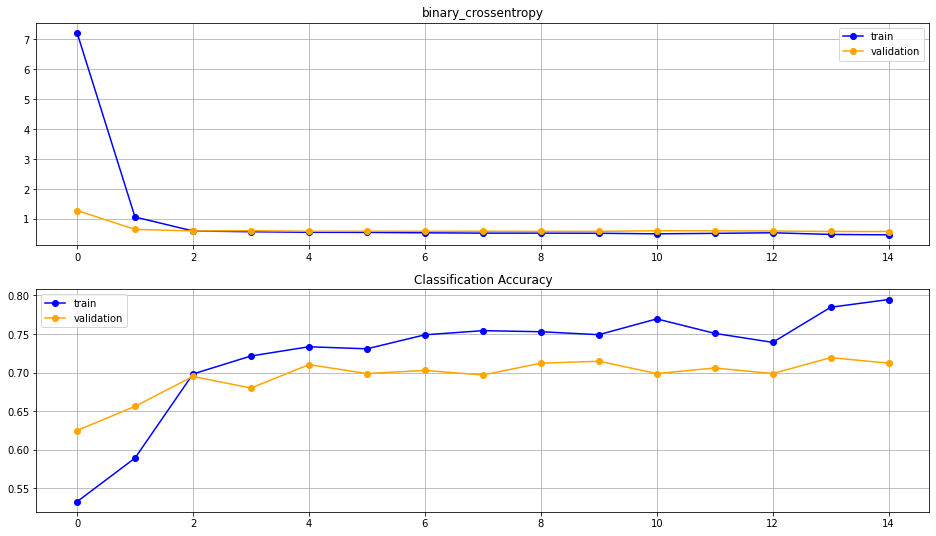

In [33]:
plot_history(history)

In [44]:
model_cnn_2 = Sequential()
model_cnn_2.add(tf.keras.layers.Input(name = "input", shape=INPUT_SHAPE))
model_cnn_2.add(tf.keras.layers.Conv2D(name = "conv2D",
                                     filters=32,
                                     kernel_size=(3,3),
                                     activation="LeakyReLU",
                                     padding="same",
                                     kernel_initializer="he_uniform"
                                    ))
model_cnn_2.add(tf.keras.layers.MaxPooling2D(name="pooling", pool_size=(2,2)))
model_cnn_2.add(tf.keras.layers.Conv2D(name = "conv2D_2",
                                     filters=64,
                                     kernel_size=(3,3),
                                     activation="LeakyReLU",
                                     padding="same",
                                     kernel_initializer="he_uniform"
                                    ))
model_cnn_2.add(tf.keras.layers.MaxPooling2D(name="pooling_2", pool_size=(2,2)))
model_cnn_2.add(tf.keras.layers.Flatten(name="flatten"))
model_cnn_2.add(tf.keras.layers.Dense(name="dense_hidden", units = 256, activation="LeakyReLU",
                                    kernel_initializer="he_uniform" ))
model_cnn_2.add(tf.keras.layers.Dense(name="dense_hidden_2", units = 128, activation="LeakyReLU",
                                    kernel_initializer="he_uniform" ))
model_cnn_2.add(tf.keras.layers.Dense(name="ouput", units = 1, activation="sigmoid"))


In [45]:
# compiler modele
model_cnn_2.compile(optimizer = "adam", loss ="binary_crossentropy", metrics=["accuracy"])

In [46]:
model_cnn_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pooling (MaxPooling2D)      (None, 32, 32, 32)        0         
                                                                 
 conv2D_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense_hidden (Dense)        (None, 256)               4194560   
                                                                 
 dense_hidden_2 (Dense)      (None, 128)              

In [47]:
X_train.shape

(12800, 64, 64, 3)

In [48]:
history_2 = model_cnn_2.fit(X_train, y_train_enc, epochs=EPOCHS, validation_data=(X_valid, y_valid_enc), batch_size = BATCH_SIZE,
                        )

Epoch 1/15
26/26 [==============================] - 42s 2s/step - loss: 4.2447 - accuracy: 0.5157 - val_loss: 0.7277 - val_accuracy: 0.5228
Epoch 2/15
26/26 [==============================] - 36s 1s/step - loss: 0.6775 - accuracy: 0.5728 - val_loss: 0.6290 - val_accuracy: 0.6466
Epoch 3/15
26/26 [==============================] - 36s 1s/step - loss: 0.6148 - accuracy: 0.6631 - val_loss: 0.6028 - val_accuracy: 0.6766
Epoch 4/15
26/26 [==============================] - 37s 1s/step - loss: 0.5919 - accuracy: 0.6857 - val_loss: 0.6026 - val_accuracy: 0.6903
Epoch 5/15
26/26 [==============================] - 36s 1s/step - loss: 0.5722 - accuracy: 0.7073 - val_loss: 0.5733 - val_accuracy: 0.7156
Epoch 6/15
26/26 [==============================] - 36s 1s/step - loss: 0.5471 - accuracy: 0.7259 - val_loss: 0.5613 - val_accuracy: 0.7103
Epoch 7/15
26/26 [==============================] - 36s 1s/step - loss: 0.5359 - accuracy: 0.7296 - val_loss: 0.5314 - val_accuracy: 0.7391
Epoch 8/15
26/26 [==

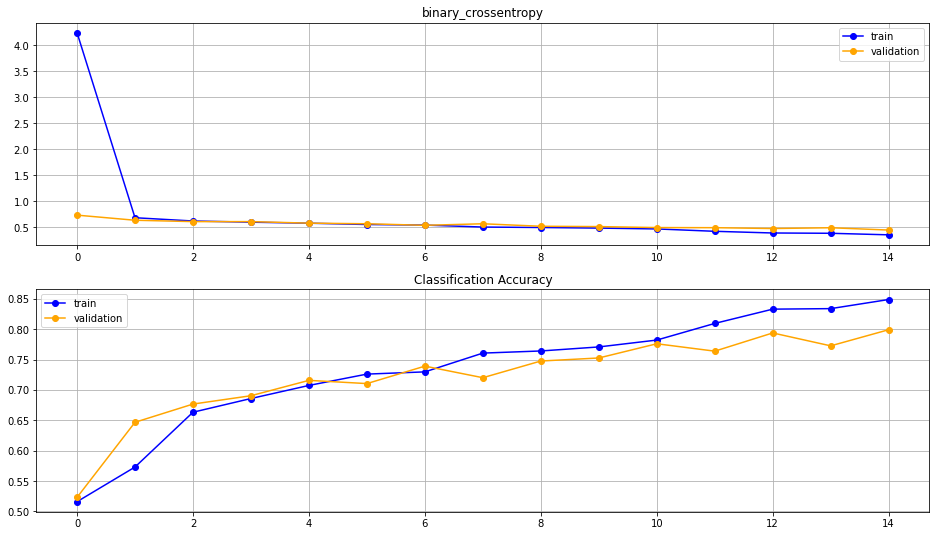

In [49]:
plot_history(history_2)

In [61]:
model_cnn_2.save(PATH_MODEL + "/model_cnn_2.h5")

In [63]:
tf.keras.__version__

'2.7.0'

In [ ]:
# assert False

In [ ]:
# modele article

In [ ]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [ ]:

model_cnn_3 = Sequential()
model_cnn_3.add(tf.keras.layers.Input(name = "input", shape=INPUT_SHAPE))

model_cnn_3.add(tf.keras.layers.Conv2D(name = "conv2D",
                                       filters=32,
                                       kernel_size=(3,3),
                                       activation="relu",
                                       padding="same",
                                       ))
model_cnn_3.add(tf.keras.layers.MaxPooling2D(name="pooling",
                                             pool_size=(2,2)
                                            ))
model_cnn_3.add(tf.keras.layers.Conv2D(name = "conv2D_2",
                                       filters=64,
                                       kernel_size=(3,3),
                                       activation="relu",
                                       padding="same",
                                       ))
model_cnn_3.add(tf.keras.layers.MaxPooling2D(name="pooling_2",
                                             pool_size=(2,2)
                                            ))
model_cnn_3.add(tf.keras.layers.Conv2D(name="conv2D_3",
                                       filters=128,
                                       kernel_size=(3,3),
                                       activation="relu",
                                       padding="same",
                                      ))
model_cnn_3.add(tf.keras.layers.MaxPooling2D(name="pooling_3",
                                             pool_size=(2,2)
                                            ))
model_cnn_3.add(tf.keras.layers.Flatten(name="flatten"))
model_cnn_3.add(tf.keras.layers.Dense(name="dense_hidden",
                                      units = 512,
                                      activation="relu",
                                     ))
model_cnn_3.add(tf.keras.layers.Dropout(name="drop_1",
                                      rate=0.3,                                      
                                     ))
model_cnn_3.add(tf.keras.layers.Dense(name="dense_hidden_2",
                                      units = 512,
                                      activation="relu",
                                     ))
model_cnn_3.add(tf.keras.layers.Dropout(name="drop_2",
                                      rate=0.3,                                      
                                     ))
model_cnn_3.add(tf.keras.layers.Dense(name="ouput", units = 1, activation="sigmoid"))

In [ ]:
# compiler modele
model_cnn_3.compile(optimizer = "adam", loss ="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model_cnn_3.summary()

In [ ]:
history_3 = model_cnn_3.fit(X_train, y_train_enc,
                            epochs=EPOCHS, validation_data=(X_valid, y_valid_enc),
                            batch_size = BATCH_SIZE
                           )

In [ ]:
plot_history(history_3)

Keras avec GPU AMD
https://medium.com/@Vatsal410/keras-without-nvidia-gpus-with-plaidml-and-amd-gpu-4ba6f60025ce